In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib

import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
import os
img_path = os.getenv("HOME")+"/aiffel/human_segmentation/images/yong2.png"
img_orig = cv2.imread(img_path)
print(img_orig.shape)

(2880, 2160, 3)


# 1. image Segmentation

- 이미지에서 픽셀 단위로 관심 객체를 추출하는 방법
- 모든 픽셀에 라벨을 할당하고 같은 라벨은 공통적인 특징을 가진다고 가정한다.

## 1.1 semantic segmentation
- 이미지에서 픽셀을 물리적인 단위로 분류하는 방법
- 사람이 누구인지 관계없이 같은 라벨로 표현된다

## 1.2 instance segmentation
- 사람 개개인별로 다른 라벨을 가지게 한다.

# 2. DeepLab
- segmentation문제에는 FCN, SegNet, U-Net 등 많은 모델이 사용되는데, DeepLab이라는 segmentation model을 만들고 모델에 이미지를 입력한다.

## 2.1 DeepLab에서 Atrous Convolution을 사용하는 이유
- 이미지 분석 중 semantic segmentation 은 중요한 방법 중 하나.
- 입력 영상에 주어진 각 픽셀에 대해서 class label을 할당하는 것을 목표로 한다.
- Atrous convolution은 기존 convolution과는 다르게 필터 내부에 빈 공간을 둔채로 작동한다. 빈 공간을 둘 지 결정하는 파라미터인 rate=1 이면, 기존 convolution과 동일하고, r이 커질수록 빈공간이 넓어진다.
- 기존 convolution과 동일한 양의 파라미터와 계산량을 유지하면서도, field of view를 크게 가져갈 수 있다.
- 보통 semantic segmentation에서 높은 성능을 내기 위해서는 마지막에 존재하는 한 픽셀이 입력값에서 어느 크기의 영역을 커버할 수 있는지를 결정하는 receptive field크기가 중요하게 작용하는데, Atrous conv는 파라미터 수를 늘리지 않으면서 receptive field를 크게 키울 수 있기 때문에 사용

## 2.2 Depthwise separable convolution
- 기존 convolution과 유사한 성능을 보이면서도 사용되는 파라미터 수와 연산량을 획기적으로 줄일 수 있기 때문
- 입력값 8X8X3, 16개의 3X3 filter일때 파라미터 개수차이는

Convolution 432개

Depthwise separable convolution : 75개

- 기존 Convolution filter가 spatial dimension과 channel dimenstion을 동시에 처리하던 것을 따로 분리시켜서 각각 처리
- spatial dimension처리에 필요한 파라미터를 하나로 공유함으로써 파라미터 수를 더 줄인다.

In [3]:
# DeepLab 모델
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

- ```preprocess()```는 전처리, ```run()``` 은 segmentation함수
- 모델이 받는 입력 크기가 정해져있으므로 적절한 크기로 resize하고 RGB로 수정

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [5]:
img_resized, seg_map = MODEL.run(img_orig)
print(img_orig.shape, img_resized.shape, seg_map.max())

(2880, 2160, 3) (513, 384, 3) 15


- seg_map.max()는 segmentation맵에서 물체로 인식된 라벨 중 가장 큰 값

In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

- background를 제외하면 20개의 클래스

### Label names에서 person만 검출

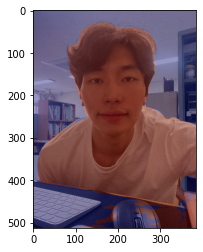

In [7]:
# 마스크를 만들고 시각화
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15,15,0) # 예측 중 사람만
img_mask = seg_map*(255/seg_map.max())
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35,0.0)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

- 사람을 뜻하는 15 외의 예측들은 0으로 만들었다.
- 일반 이미지는 0부터 255까지의 값을 사용하여 픽셀을 표현하므로, segmentation map에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위하여 255로 정규화한다.
- segmentation map에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해 255로 정규화 한다.
- applyColorMap()함수로 색을 적용하고 이미지를 화면에 출력한다.

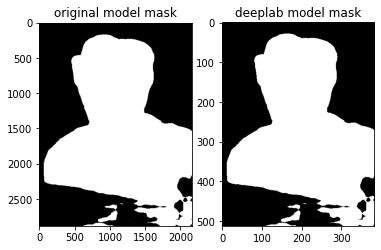

In [8]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128,255, cv2.THRESH_BINARY)
ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap = plt.cm.binary_r)
ax.set_title('original model mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('deeplab model mask')
plt.show()

- ```cv2.resize()``` 함수를 이용한다. 크기를 키울 때 보간을 고려해야하는데, 정확하게 하기위하여 ```cv2.INTER_LINEAR```를 사용한다.
- 보간법은 이미지의 크기를 변경하는 과정에서 컴퓨터가 사이사이 픽셀값을 채우는 방법.
- 결과적으로 img_mask_up은 경계가 블러된 픽셀값 0~255의 이미지를 얻습니다. 확실한 경계를 다시 정하기 위하여 중간값인 128을 기준으로 임계값 설정
- 128이하의 값은 0으로 128 이상의 값은 255로

### 배경흐리게 blur

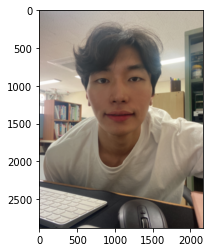

In [9]:
img_orig_blur = cv2.blur(img_orig, (13,13))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

흐려진 이미지에서 segmentation mask를 이용하여 배경만 추출

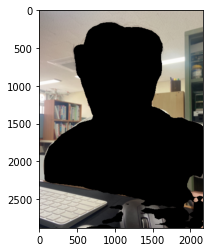

In [10]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_BGR2RGB)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

- ``` bitwise_not``` 함수는 이미지가 반전되고 배경은 255 사람은 0이된다.
- segmentation결과를 이용하여 이미지와``` bitwise_and``` 연산을 수행하면 배경만 있는 영상을 얻을 수 있다.

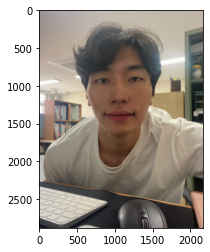

In [11]:
# 배경과 사람 영상 합치기
img_concat = np.where(img_mask_color ==255, img_orig,img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# segmentation의 한계

- 피사계심도를 이용한 아웃포커싱 효과는 심도를 표현하기 때문에 초점이 잡힌 거리를 광학적으로 아주 섬세하게 구별하지만 정확도가 1.00이 되지 않는 한 완벽히 구현하기는 힘들다.


### 피사계심도
- 아웃포커싱은 DSLR의 수동모드 상태로 촬영
- 조리개를 개방할 수록 좋고, 셔터 스피드는 느릴 수록 좋다.
- 빛을 많이 받아들일 수록 아웃포커싱이 잘된다라는 뜻.

- 피사체가가까울수록, 피사체와 주변 사물과의 거리가 멀수록 잘된다.

### 3D Depth camera
- 이미지 각 픽셀의 깊이 값을 계산 할 수 있는 기술이다.
- 다양한 기법들로 픽셀의 깊이를 계산하여 3D이미지를 나타낸다.
- 피사체들로부터 렌즈를 통해 들어오는 이미지에 연산을 통해서 이미지를 재가공해서 이미지를 만들어 내는 카메라

#### 스테레오
- 두 개의 2D 이미지 센서를 결합해서 만든 입체 영상.
- 측정 대상과의 거리를 측정하기 위하여 한 쌍의 동일한 카메라로 시점 불일치를 이용
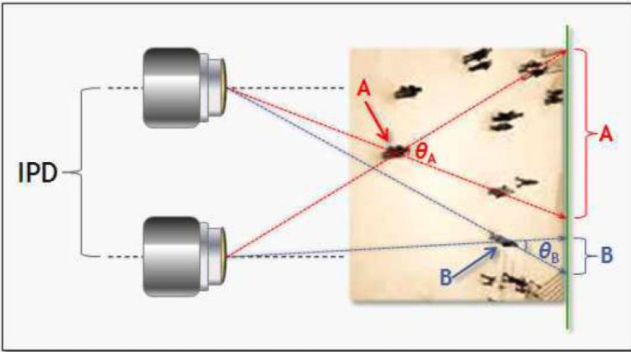

#### ToF(Time Of Flight)
- 모든 픽셀에 대한 변조 된 광 신호의 지연 또는 위상 시프트를 측정하여 이동시간 정보 획득
- 전송 된 신호에 대해 수신 된 광 신호의 지연을 측정
#### Structured pattern
- 구조화 된 빛 한 세트의 패턴을 대상에 투사하고 이미지 센서로 결과 이미지를 캡처하는 광학 3D 스캐닝 방법
- 구조화 된 빛은 입체 시각 센서의 두 번째 이미지 센서를 투영 구성 요소로 대체한다.